# Brain Tumor Classification Data Pipeline

After Analyzing the MRI Image What I notice is:

1- different Image Format (JEPG, JPG) so this need to be fixed.

2- Image name need to be fix as well .

3- data augmentation. (Use it to handle class Imnalance)

## Setup & Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Rename images to `.jpg`  
Makes sure *yes* / *no* folders contain only `.jpg` files.

In [19]:
import os
from pathlib import Path

def rename_images(folder: str, prefix: str = "Y") -> None:
    folder_path = Path(folder)
    if not folder_path.is_dir():
        raise FileNotFoundError(f"{folder} is not a valid directory")

    to_rename = sorted(
        [p for p in folder_path.iterdir()
         if p.is_file() and not p.name.lower().startswith(f"{prefix.lower()}_")]
    )

    next_idx = 1
    for src in to_rename:
        ext = src.suffix.lower()        
        while True:
            dst = folder_path / f"{prefix}_{next_idx}{ext}"
            if not dst.exists():
                break
            next_idx += 1                 
        src.rename(dst)
        next_idx += 1                     

    print(f"Renamed {len(to_rename)} files in '{folder_path.name}'")


rename_images("brain_tumor_dataset/yes", prefix="Y")
rename_images("brain_tumor_dataset/no",  prefix="N")


Renamed 0 files in 'yes'
Renamed 0 files in 'no'


## Count images
check of class balance.

In [20]:
def count_brain_tumor_classes(folder="brain_tumor_dataset"):
    yes_count = len(os.listdir(os.path.join(folder, "yes")))
    no_count = len(os.listdir(os.path.join(folder, "no")))
    
    print(f"Number of 'yes' (tumor) images: {yes_count}")
    print(f"Number of 'no' (no tumor) images: {no_count}")
    
    return yes_count, no_count


count_brain_tumor_classes()

Number of 'yes' (tumor) images: 154
Number of 'no' (no tumor) images: 98


(154, 98)

Number of 'yes' (tumor) images: 154
Number of 'no' (no tumor) images: 98


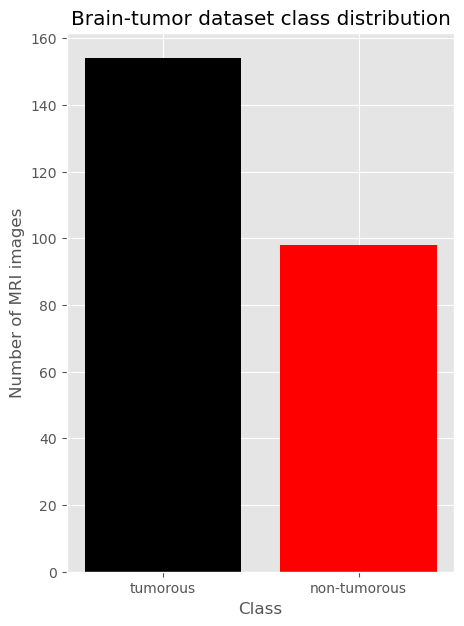

In [21]:
import matplotlib.pyplot as plt

yes_count, no_count = count_brain_tumor_classes()   

data = {'tumorous': yes_count, 'non‑tumorous': no_count}

plt.figure(figsize=(5, 7))
plt.bar(data.keys(), data.values(), color=["black", "red"])
plt.xlabel("Class")
plt.ylabel("Number of MRI images")
plt.title("Brain‑tumor dataset class distribution")
plt.show()

## Handle data Imbalance using data Augemention

In [22]:
from pathlib import Path
def class_counts(dataset_dir="brain_tumor_dataset"):
    yes = Path(dataset_dir) / "yes"
    no  = Path(dataset_dir) / "no"
    return {"yes": len(list(yes.iterdir())), "no": len(list(no.iterdir()))}

def balance_with_augmentation(
    src_dir="brain_tumor_dataset",
    dst_dir="brain_tumor_dataset_balanced",
    aug_factor=1.2,             
    seed=42
):
    counts = class_counts(src_dir)
    print("Current counts:", counts)

    # Choose the minority class
    minority_class = min(counts, key=counts.get)
    majority_class = max(counts, key=counts.get)
    needed = counts[majority_class] - counts[minority_class]
    if needed <= 0:
        print("Dataset already balanced")
        return

    print(f" Need {needed} extra '{minority_class}' images")

    # Create destination folders
    Path(dst_dir, "yes").mkdir(parents=True, exist_ok=True)
    Path(dst_dir, "no").mkdir(parents=True, exist_ok=True)

    # Copy originals first (optional but handy)
    for cls in ("yes", "no"):
        for file in (Path(src_dir) / cls).iterdir():
            if file.is_file():
                target = Path(dst_dir) / cls / file.name
                if not target.exists():
                    target.write_bytes(file.read_bytes())

    # augmentation setup
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=(0.9, 1.1),
        fill_mode="nearest"
    )

    minority_dir = Path(src_dir) / minority_class
    save_to_dir  = Path(dst_dir) / minority_class

    generated = 0
    rng = np.random.default_rng(seed)

    # Keep looping over minority images until we reach the target
    while generated < needed:
        img_path = rng.choice(list(minority_dir.iterdir()))
        img = load_img(img_path)               
        x   = img_to_array(img)               
        x   = x.reshape((1,) + x.shape)       

        # Take just one variant at a time
        for batch in datagen.flow(
            x,
            batch_size=1,
            save_to_dir=save_to_dir,
            save_prefix="aug",
            save_format="jpg",
            seed=rng.integers(1e6)
        ):
            generated += 1
            if generated >= needed:
                break

    # Final sanity check
    new_counts = {
        "yes": len(list((Path(dst_dir) / "yes").iterdir())),
        "no":  len(list((Path(dst_dir) / "no").iterdir()))
    }
    print("Balanced counts:", new_counts)
balance_with_augmentation()


Current counts: {'yes': 154, 'no': 98}
 Need 56 extra 'no' images
Balanced counts: {'yes': 154, 'no': 154}


In [23]:
def data_summary(main_path: str = "augmented_data") -> dict:
    main_path = Path(main_path)
    yes_path  = main_path / "yes"
    no_path   = main_path / "no"

    # Count only files (ignore accidental sub‑dirs)
    n_pos = len([p for p in yes_path.iterdir() if p.is_file()])
    n_neg = len([p for p in no_path.iterdir() if p.is_file()])

    n_total = n_pos + n_neg
    if n_total == 0:
        raise ValueError(f"No images found under {main_path}")

    pos_pct = (n_pos / n_total) * 100
    neg_pct = (n_neg / n_total) * 100

    print(f"Total samples          : {n_total}")
    print(f"Positive (tumorous)    : {n_pos}  ({pos_pct:.2f} %)")
    print(f"Negative (non‑tumorous): {n_neg}  ({neg_pct:.2f} %)")

    return {
        "total": n_total,
        "n_positive": n_pos,
        "n_negative": n_neg,
        "positive_pct": pos_pct,
        "negative_pct": neg_pct,
    }
data_summary("brain_tumor_dataset_balanced")

Total samples          : 308
Positive (tumorous)    : 154  (50.00 %)
Negative (non‑tumorous): 154  (50.00 %)


{'total': 308,
 'n_positive': 154,
 'n_negative': 154,
 'positive_pct': 50.0,
 'negative_pct': 50.0}

## rezise the balanced dataset

In [24]:
import os
import cv2
import numpy as np

IMG_SIZE = 128  # Resize all images to 128x128 pixels

def load_and_preprocess_data(directory, label):
    images = []
    labels = []
    for file in os.listdir(directory):
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # grayscale
        if img is None:
            print(f"Warning: failed to read {img_path}, skipping.")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))       # resize
        img = img / 255.0                                 # normalize to [0,1]
        images.append(img)
        labels.append(label)
    return images, labels

def load_dataset(base_dir):
    yes_dir = os.path.join(base_dir, "yes")
    no_dir  = os.path.join(base_dir, "no")

    yes_images, yes_labels = load_and_preprocess_data(yes_dir, 1)
    no_images, no_labels   = load_and_preprocess_data(no_dir, 0)

    images = np.array(yes_images + no_images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    labels = np.array(yes_labels + no_labels)

    print(f"Loaded {len(images)} images: {sum(labels)} tumorous, {len(labels)-sum(labels)} non-tumorous.")
    return images, labels


images, labels = load_dataset("brain_tumor_dataset_balanced")


Loaded 308 images: 154 tumorous, 154 non-tumorous.


In [25]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]
    
    image_width, image_height=image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)
    
    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

BASE_DIR = "brain_tumor_dataset_balanced"
dirs = [os.path.join(BASE_DIR, "yes"),
        os.path.join(BASE_DIR, "no")]

# Desired output resolution
size = (128, 128)

X, y = load_data(dirs , size)

Number of example is : 308
X SHAPE is : (308, 128, 128, 3)
y SHAPE is : (308,)


##  Create train / val / test splits (80 / 10 / 10)  
Saves each split into its own directory for Keras’ `image_dataset_from_directory`. then normalize and prefetch


In [26]:
import tensorflow as tf

def load_datasets(data_dir="brain_tumor_dataset_balanced", img_size=(128, 128), batch_size=32):
    # Step 1: Load training data (70%)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="binary",
        color_mode="rgb",  
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.3,
        subset="training",
        seed=123
    )

    # Step 2: Load remaining 30% for validation and test
    val_test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="binary",
        color_mode="rgb",
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.3,
        subset="validation",
        seed=123
    )

    # Step 3: Split the 30% into 15% validation and 15% test
    val_batches = tf.data.experimental.cardinality(val_test_ds).numpy() // 2
    val_ds = val_test_ds.take(val_batches)
    test_ds = val_test_ds.skip(val_batches)

    # Step 4: Normalize and prefetch
    normalization = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization(x), y)).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.map(lambda x, y: (normalization(x), y)).cache().prefetch(tf.data.AUTOTUNE)
    test_ds  = test_ds.map(lambda x, y: (normalization(x), y)).cache().prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

# Example usage
train_ds, val_ds, test_ds = load_datasets()


Found 308 files belonging to 2 classes.
Using 216 files for training.
Found 308 files belonging to 2 classes.
Using 92 files for validation.


In [27]:
for images, labels in train_ds.take(1):
    print("Batch shape:", images.shape)  
    print("Labels     :", labels.numpy()[:10])

Batch shape: (32, 128, 128, 3)
Labels     : [[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]]


## Simple CNN

In [28]:

import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = (128, 128) 
INPUT_SHAPE = (*IMG_SIZE, 3)  

# Build the model
def build_simple_cnn():
    model = models.Sequential([
        # 1. Convolutional layer1 
        layers.Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        layers.MaxPooling2D((2,2)),  
        
        # 2. Second Conv layer
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        # 3. Third Conv layer
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        # Classification Head
        layers.Flatten(),

        # Fully connected layer: Learn patterns across all features
        layers.Dense(128, activation='relu'),
        
        # Dropout for regularization (reduces overfitting)
        layers.Dropout(0.5),

        # Output layer: Sigmoid activation for binary classification (tumor/no tumor)
        layers.Dense(1, activation='sigmoid')
    ])


    model.compile(
        optimizer='adam',  
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


model = build_simple_cnn()

model.summary()


C:\Users\jinan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)               │ (None, 126, 126, 32)  │          896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 63, 63, 32)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_1 (Conv2D)             │ (None, 61, 61, 64)    │       18,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_1               │ (None, 30, 30, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_2 (Conv2D)             │ (None, 28, 28, 128)   │       73,856 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_2               │ (None, 14, 14, 128)   │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten (Flatten)             │ (None, 25088)         │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 128)           │    3,211,392 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout (Dropout)             │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_1 (Dense)               │ (None, 1)             │          129 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - accuracy: 0.6295 - loss: 0.6232 - val_accuracy: 0.6875 - val_loss: 0.6373
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.7649 - loss: 0.4841 - val_accuracy: 0.8125 - val_loss: 0.5582
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.8217 - loss: 0.4079 - val_accuracy: 0.8125 - val_loss: 0.5068
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.8391 - loss: 0.3737 - val_accuracy: 0.7812 - val_loss: 0.5810
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.8608 - loss: 0.3946 - val_accuracy: 0.7812 - val_loss: 0.4683
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.9040 - loss: 0.2755 - val_accuracy: 0.8125 - val_loss: 0.5420
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.9277 - loss: 0.2097 - val_accuracy: 0.7812 - val_loss: 0.5144
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.9366 - loss: 0.1673 - val_accuracy: 0.8125 - val_loss:

In [30]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9132 - loss: 0.2554
Test accuracy: 91.67%


In [31]:
model.save("brain_tumor_cnn_model.h5")

## Deeper CNN with BatchNorm & Dropout

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, Model

IMG_SIZE = (128, 128)
INPUT_SHAPE = (*IMG_SIZE, 3)

def build_deep_cnn_functional():
    inputs = layers.Input(shape=INPUT_SHAPE)

    # Block 1
    x = layers.Conv2D(32, (3,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 2
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 3
    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)

    # Global Average Pooling replaces Flatten
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layer + BatchNorm + Dropout
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer 
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

cnn_model = build_deep_cnn_functional()
cnn_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)   │ (None, 128, 128, 3)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)  │          896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization           │ (None, 128, 128, 32)  │          128 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ activation (Activation)       │ (None, 128, 128, 32)  │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_3               │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_1 (Dropout)           │ (None, 64, 64, 32)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)    │       18,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_1         │ (None, 64, 64, 64)    │          256 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ activation_1 (Activation)     │ (None, 64, 64, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_4               │ (None, 32, 32, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_2 (Dropout)           │ (None, 32, 32, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 128)   │       73,856 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_2         │ (None, 32, 32, 128)   │          512 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ activation_2 (Activation)     │ (None, 32, 32, 128)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_5               │ (None, 16, 16, 128)   │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_3 (Dropout)           │ (None, 16, 16, 128)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ global_average_pooling2d      │ (None, 128)           │            0 │
│ (GlobalAveragePooling2D)      │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_2 (Dense)               │ (None, 256)           │       33,024 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_3         │ (None, 256)           │        1,024 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ activation_3 (Activation)     │ (None, 256)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_4 (Dropout)           │ (None, 256)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_3 (Dense)               │ (None, 1)             │          257 │
└───────────────────────────────┴───────────────────────┴─

 Total params: 128,449 (501.75 KB)

 Trainable params: 127,489 (498.00 KB)

 Non-trainable params: 960 (3.75 KB)

In [33]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

model.save("deep_cnn_brain_tumor.h5")

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.9777 - loss: 0.0794 - val_accuracy: 0.9062 - val_loss: 0.5261
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.9740 - loss: 0.0694 - val_accuracy: 0.8125 - val_loss: 0.6056
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.9810 - loss: 0.0609 - val_accuracy: 0.8438 - val_loss: 0.7632
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.9766 - loss: 0.0636 - val_accuracy: 0.8125 - val_loss: 0.6141
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.9982 - loss: 0.0312 - val_accuracy: 0.9062 - val_loss: 0.6597
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.9963 - loss: 0.0151 - val_accuracy: 0.9062 - val_loss: 0.7291
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.9949 - loss: 0.0198 - val_accuracy: 0.8750 - val_loss: 0.7823
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.9062 - val_loss:

In [34]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9458 - loss: 0.3251
Test accuracy: 95.00%


##  RadImageNet	Pretrained models on radiology images (CT, MRI, etc.).

## https://drive.google.com/file/d/1UgYviv2K6QPM1SCexqqab5-yTgwoAFEc/view

Backbone	File name in Drive	           Input size
ResNet50	RadImageNet‑ResNet50_notop.h5	224 × 224

In [35]:
pip install -q gdown

Note: you may need to restart the kernel to use updated packages.


In [46]:
!gdown --id 1UgYviv2K6QPM1SCexqqab5-yTgwoAFEc -O RadImageNet_models.zip

import zipfile, pathlib, shutil

with zipfile.ZipFile("RadImageNet_models.zip") as z:
    member = [m for m in z.namelist() if "ResNet50_notop.h5" in m][0]
    z.extract(member, ".")                  
    weights_path = pathlib.Path(member).name
    shutil.move(member, weights_path)

print("Weights available at:", weights_path)

C:\Users\jinan\anaconda3\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1UgYviv2K6QPM1SCexqqab5-yTgwoAFEc
From (redirected): https://drive.google.com/uc?id=1UgYviv2K6QPM1SCexqqab5-yTgwoAFEc&confirm=t&uuid=bec32a59-c29e-4b32-9330-015d64487b24
To: C:\Users\jinan\Deep-Learning\project-2\RadImageNet-ResNet50_notop.h5

  0%|          | 0.00/1.82G [00:00<?, ?B/s]
  0%|          | 524k/1.82G [00:00<28:16, 1.07MB/s]
  0%|          | 1.57M/1.82G [00:00<10:42, 2.83MB/s]
  0%|          | 2.62M/1.82G [00:00<06:41, 4.53MB/s]
  0%|          | 4.19M/1.82G [00:00<04:45, 6.36MB/s]
  0%|          | 5.24M/1.82G [00:01<04:15, 7.12MB/s]
  0%|          | 6.82M/1.82G [00:01<03:36, 8.38MB/s]
  0%|          | 8.39M/1.82G [00:01<03:20, 9.07MB/s]
  1%|          | 9.96M/1.82G [00:01<03:05, 9.76MB/s]
  

Weights available at: RadImageNet-ResNet50_notop.h5


In [47]:
import tensorflow as tf
IMG_SIZE = (224, 224)             # match backbone
weights_path = "RadImageNet-ResNet50_notop.h5"

# Build the SAME architecture that the weights expect
base = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,                
    input_shape=(*IMG_SIZE, 3),
    pooling="avg"                 # global‑avg‑pool so we get a 2048‑D vector
)

base.load_weights(weights_path)    # ← RadImageNet weights!

base.trainable = False             # start frozen (fine‑tune later)

model = models.Sequential([
    base,
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")      # binary: tumor / no‑tumor
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)


each batch already has shape (B, 224, 224, 3)

In [48]:
train_ds, val_ds, test_ds = load_datasets(
    data_dir="brain_tumor_dataset_balanced",
    img_size=IMG_SIZE,
    batch_size=32
)

Found 308 files belonging to 2 classes.
Using 216 files for training.
Found 308 files belonging to 2 classes.
Using 92 files for validation.


In [49]:
# quick warm‑up with frozen conv layers
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)

# unfreeze the last few blocks for fine‑tuning
for layer in base.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # low LR for fine‑tune
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)



Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6106 - auc: 0.6951 - loss: 0.6331 - val_accuracy: 0.5625 - val_auc: 0.7242 - val_loss: 0.5936
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7719 - auc: 0.8334 - loss: 0.5044 - val_accuracy: 0.7500 - val_auc: 0.8135 - val_loss: 0.5312
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7886 - auc: 0.8716 - loss: 0.4589 - val_accuracy: 0.8438 - val_auc: 0.8472 - val_loss: 0.4805
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8495 - auc: 0.9187 - loss: 0.3706 - val_accuracy: 0.8438 - val_auc: 0.8552 - val_loss: 0.4610
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8303 - auc: 0.9041 - loss: 0.3904 - val_accuracy: 0.8125 - val_auc: 0.8690 - val_loss: 0.4479
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.7919 - auc: 0.8515 - loss: 0.8130 - val_accuracy: 0.8438 - val_auc: 0.8710 - val_loss: 0.4533
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8219 - au

[0.49230071902275085, 0.8166666626930237, 0.8702857494354248]

## Do not explain

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pathlib, datetime


In [52]:
def load_datasets(data_dir="brain_tumor_dataset_balanced",
                  img_size=(224, 224),  # 224 for ResNet‑50
                  batch_size=32,
                  seed=123):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="binary",
        color_mode="rgb",
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.3,
        subset="training",
        seed=seed
    )
    val_test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="binary",
        color_mode="rgb",
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.3,
        subset="validation",
        seed=seed
    )
    val_batches = tf.data.experimental.cardinality(val_test_ds).numpy() // 2
    val_ds  = val_test_ds.take(val_batches)
    test_ds = val_test_ds.skip(val_batches)

    #  augmentation applied only to training 
    aug = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    normalise = layers.Rescaling(1./255)

    train_ds = train_ds.map(lambda x, y: (aug(normalise(x), training=True), y))
    val_ds   = val_ds.map(lambda x, y: (normalise(x), y))
    test_ds  = test_ds.map(lambda x, y: (normalise(x), y))

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
    val_ds   = val_ds.cache().prefetch(AUTOTUNE)
    test_ds  = test_ds.cache().prefetch(AUTOTUNE)
    return train_ds, val_ds, test_ds


In [53]:
IMG_SIZE = (224, 224)
base = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(*IMG_SIZE, 3),
    pooling="avg"
)
base.load_weights("RadImageNet-ResNet50_notop.h5")

# classification head
inputs  = layers.Input(shape=(*IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = models.Model(inputs, outputs)

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])



In [54]:
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
ckpt_path = f"best_radimagenet_{timestamp}.h5"

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc",
                                     patience=3, mode="max",
                                     restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(ckpt_path,
                                       monitor="val_auc",
                                       save_best_only=True,
                                       mode="max")
]


In [58]:
# warm‑up
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5,
                    callbacks=callbacks,
                    )

# fine‑tune last 40 layers
for layer in base.layers[-40:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

history_ft = model.fit(train_ds,
                       validation_data=val_ds,
                       epochs=10,
                       callbacks=callbacks,
                       )


Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 105s 15s/step - accuracy: 0.9926 - auc: 1.0000 - loss: 0.0099 - val_accuracy: 0.8125 - val_auc: 0.8333 - val_loss: 2.2959
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0019   

7/7 ━━━━━━━━━━━━━━━━━━━━ 86s 13s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0020 - val_accuracy: 0.8125 - val_auc: 0.8512 - val_loss: 2.1253
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 88s 13s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0036 - val_accuracy: 0.7812 - val_auc: 0.8512 - val_loss: 1.9984
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 9.6782e-04 

7/7 ━━━━━━━━━━━━━━━━━━━━ 90s 13s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 9.6449e-04 - val_accuracy: 0.7812 - val_auc: 0.8611 - val_loss: 1.9214
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 87s 13s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 7.3525e-04 - val_accuracy: 0.8125 - val_auc: 0.8512 - val_loss: 1.8581
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 255s 15s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0013 - val_accuracy: 0.8125 - val_auc: 0.8611 - val_loss: 1.8715
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 88s 13s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 7.7781e-04 - val_accuracy: 0.8125 - val_auc: 0.8512 - val_loss: 1.7748
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 86s 12s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 6.1990e-04 - val_accuracy: 0.8125 - val_auc: 0.8512 - val_loss: 1.6411
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.7285e-04 

7/7 ━━━━━━━━━━━━━━━━━━━━ 94s 14s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.7385e-04 - val_accuracy: 0.8125 - val_auc: 0.8770 - val_loss: 1.5033
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 139s 12s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 5.3518e-04 - val_accuracy: 0.8125 - val_auc: 0.8730 - val_loss: 1.3833
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 7.8385e-04 

7/7 ━━━━━━━━━━━━━━━━━━━━ 97s 14s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 7.4662e-04 - val_accuracy: 0.8125 - val_auc: 0.8988 - val_loss: 1.2730
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 11s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.7949e-04 - val_accuracy: 0.8125 - val_auc: 0.8988 - val_loss: 1.1642
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.5080e-04 

7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.5281e-04 - val_accuracy: 0.8125 - val_auc: 0.9028 - val_loss: 1.0742
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.6690e-04 

7/7 ━━━━━━━━━━━━━━━━━━━━ 85s 12s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.5910e-04 - val_accuracy: 0.8438 - val_auc: 0.9286 - val_loss: 1.0016
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 11s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.2770e-04 - val_accuracy: 0.8438 - val_auc: 0.9286 - val_loss: 0.9456
